<a href="https://colab.research.google.com/github/rupeshgyawali/federated-covid-xray-detection/blob/main/centralized/covid19_xray_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download and unzip dataset

In [ ]:
# !cp /content/drive/MyDrive/MajorProject/COVID-19_Radiography_Dataset.zip /content/
!cp /content/drive/MyDrive/MajorProject/Dataset_1400.zip /content/

In [ ]:
# !gdown --id 1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
# !unzip -q COVID-19_Radiography_Database.zip
# !gdown 10yfPVbWYhaZck9Z5ujE2IA2RmcEHadTP
# !unzip -q COVID-19_Radiography_Dataset.zip
!unzip -q Dataset_1400.zip -d Dataset_1400

In [ ]:
# !rm -r COVID-19_Radiography_Dataset/**/masks/
# !mv COVID-19_Radiography_Dataset/COVID/images/* COVID-19_Radiography_Dataset/COVID/
# !mv COVID-19_Radiography_Dataset/Lung_Opacity/images/* COVID-19_Radiography_Dataset/Lung_Opacity/
# !mv COVID-19_Radiography_Dataset/Normal/images/* COVID-19_Radiography_Dataset/Normal/
# !mv COVID-19_Radiography_Dataset/Viral\ Pneumonia/images/* COVID-19_Radiography_Dataset/Viral\ Pneumonia
# !rm -r COVID-19_Radiography_Dataset/**/images

In [ ]:
# from pathlib import Path

# # Balancing dataset
# basepath = Path('COVID-19_Radiography_Dataset/')
# for entry in basepath.iterdir():
#   if entry.is_dir():
#     for i, file_ in enumerate(entry.iterdir()):
#       if i < 1400:
#         continue
#       file_.unlink()

### Import necessary libraries

In [ ]:
import PIL
import tensorflow as tf


### Explore Dataset

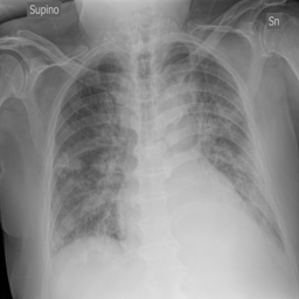

In [ ]:
# PIL.Image.open('/content/COVID-19_Radiography_Dataset/COVID/COVID-1.png')
PIL.Image.open('/content/Dataset_1400/COVID/COVID-10.png')

### Preprocessing and visualization of data

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
# dataset_path = '/content/COVID-19_Radiography_Dataset'
dataset_path = '/content/Dataset_1400'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path, seed=123, validation_split=0.2, subset="training", batch_size=batch_size, image_size=(img_height, img_width))
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path, seed=123, validation_split=0.2, subset="validation", batch_size=batch_size, image_size=(img_height, img_width))

Found 5545 files belonging to 4 classes.
Using 4436 files for training.
Found 5545 files belonging to 4 classes.
Using 1109 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

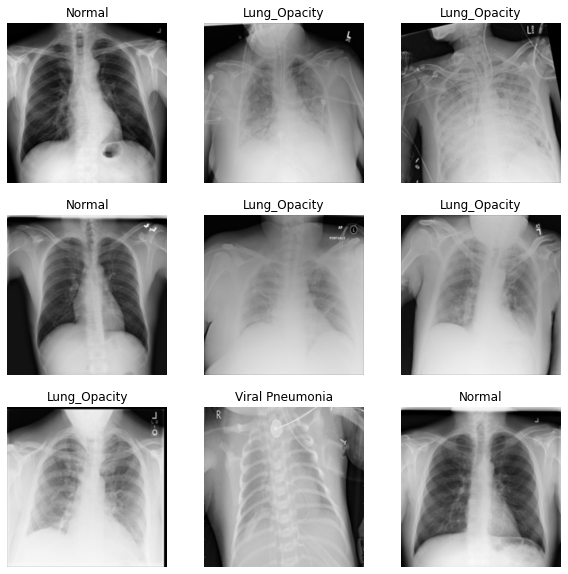

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
# from sklearn.model_selection import train_test_split

# train_test_split([0,1,2,3,4,5,6,7,8,9], [00,11,22,33,44,55,66,77,88,99], test_size=0.1)

### Configure the dataset for performance

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(11000).prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalize the Data

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8376328


### Building and compling model




In [ ]:
num_classes = len(class_names)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./256, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes),
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

### Train the model

In [ ]:
epochs = 10
tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir='/content/drive/MyDrive/MajorProject/logs/experiment1/centralized/')
csv_logger = tf.keras.callbacks.CSVLogger(
            '/content/drive/MyDrive/MajorProject/logs/experiment1/centralized/' + 'training.log', 
            append=True)

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, callbacks=[tensorboard_callback, csv_logger])

Epoch 1/10
139/139 [==============================] - 26s 97ms/step - loss: 0.8602 - accuracy: 0.6526 - val_loss: 0.5678 - val_accuracy: 0.7782
Epoch 2/10
139/139 [==============================] - 13s 92ms/step - loss: 0.5011 - accuracy: 0.8068 - val_loss: 0.4819 - val_accuracy: 0.8106
Epoch 3/10
139/139 [==============================] - 13s 92ms/step - loss: 0.3626 - accuracy: 0.8609 - val_loss: 0.4774 - val_accuracy: 0.8034
Epoch 4/10
139/139 [==============================] - 13s 92ms/step - loss: 0.2868 - accuracy: 0.8884 - val_loss: 0.4335 - val_accuracy: 0.8503
Epoch 5/10
139/139 [==============================] - 14s 97ms/step - loss: 0.1945 - accuracy: 0.9252 - val_loss: 0.5370 - val_accuracy: 0.8215
Epoch 6/10
139/139 [==============================] - 16s 112ms/step - loss: 0.1490 - accuracy: 0.9452 - val_loss: 0.4988 - val_accuracy: 0.8458
Epoch 7/10
139/139 [==============================] - 13s 93ms/step - loss: 0.1051 - accuracy: 0.9621 - val_loss: 0.5473 - val_accuracy

### Visualize training

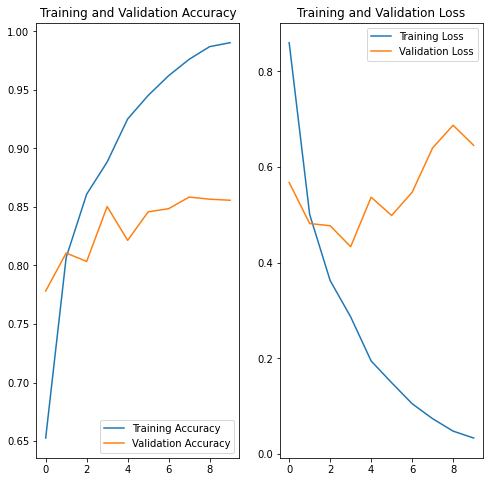

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Optimizing model

### Data agumentation

In [ ]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

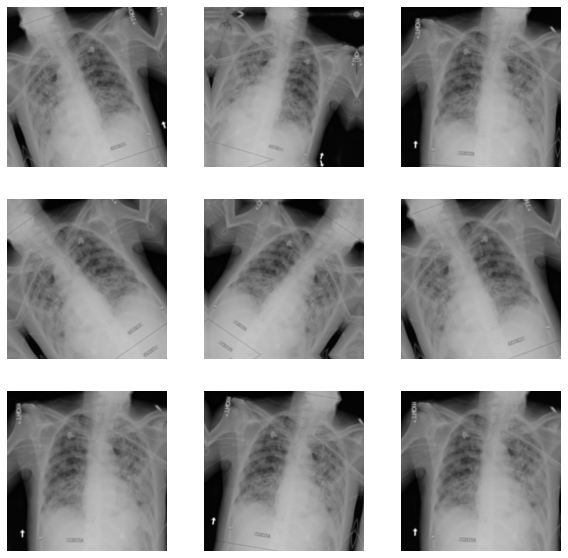

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout layer

In [ ]:
num_classes = len(class_names)

model2 = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./256, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
epochs = 100
tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir='/content/drive/MyDrive/MajorProject/logs/experiment2/centralized/')
csv_logger = tf.keras.callbacks.CSVLogger(
            '/content/drive/MyDrive/MajorProject/logs/experiment2/centralized/' + 'training.log', 
            append=True)

In [ ]:
history2 = model2.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback, csv_logger]
)

Epoch 1/100
139/139 [==============================] - 15s 99ms/step - loss: 1.0654 - accuracy: 0.5192 - val_loss: 0.8323 - val_accuracy: 0.6763
Epoch 2/100
139/139 [==============================] - 14s 96ms/step - loss: 0.8587 - accuracy: 0.6289 - val_loss: 0.7490 - val_accuracy: 0.7096
Epoch 3/100
139/139 [==============================] - 14s 95ms/step - loss: 0.7668 - accuracy: 0.6752 - val_loss: 0.6941 - val_accuracy: 0.7250
Epoch 4/100
139/139 [==============================] - 14s 94ms/step - loss: 0.7086 - accuracy: 0.7092 - val_loss: 0.6091 - val_accuracy: 0.7619
Epoch 5/100
139/139 [==============================] - 14s 95ms/step - loss: 0.6674 - accuracy: 0.7250 - val_loss: 0.6013 - val_accuracy: 0.7710
Epoch 6/100
139/139 [==============================] - 14s 95ms/step - loss: 0.6508 - accuracy: 0.7288 - val_loss: 0.6695 - val_accuracy: 0.7376
Epoch 7/100
139/139 [==============================] - 14s 95ms/step - loss: 0.6193 - accuracy: 0.7516 - val_loss: 0.5526 - val_ac

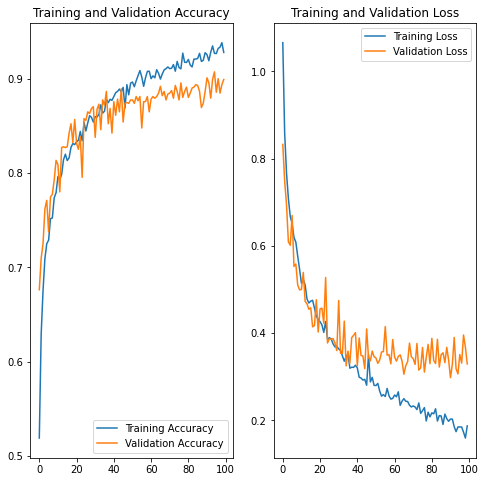

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make predictions

In [ ]:
img = tf.keras.utils.load_img('/content/Dataset_1400/COVID/COVID-10.png', target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to COVID with a 99.91 percent confidence.
